# Network of Vector Similarity

In [1]:
import os, string, warnings, glob, gensim, re, itertools, math, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Network libraries.
import networkx as nx
from networkx.algorithms import community
from networkx.readwrite import json_graph

# Ignore warnings.
warnings.simplefilter("ignore")

# Declare directory.
abs_dir = "/Users/williamquinn/Documents/DH/"

/Users/williamquinn/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Import Data

In [2]:
%%time

# Import model.
model = gensim.models.KeyedVectors.load_word2vec_format(abs_dir + 'Python/MJP/Word-Doc_Vectors/Models/mjp_w2v.txt')

# Import dataframe.
data = pd.read_csv(abs_dir + 'GitHub/DH2022_SemanticEmergence/Data_Outputs/new-vectors_CI.csv', 
                   sep = '\t')

data = data.query('(meta_type == "articles") & (meta_magazine == "Marsden Magazines")')

data.head()

CPU times: user 1.92 s, sys: 65.7 ms, total: 1.99 s
Wall time: 2.05 s


,meta_mjp_id,meta_magazine,meta_type,meta_date,meta_year,vector,keyword,mean,count,std,ci_hi,ci_lo
86,84,Marsden Magazines,articles,1918-08-01,1918,84_man,man,0.743164,41,0.016943,0.748350,0.737978
88,91,Marsden Magazines,articles,1914-08-01,1914,91_ego,ego,0.636399,41,0.053830,0.652877,0.619922
89,91,Marsden Magazines,articles,1914-08-01,1914,91_man,man,0.745765,41,0.013875,0.750012,0.741518
90,91,Marsden Magazines,articles,1914-08-01,1914,91_woman,woman,0.675112,41,0.018317,0.680719,0.669505
91,91,Marsden Magazines,articles,1914-08-01,1914,91_ego,ego,0.636399,41,0.053830,0.652877,0.619922


## Build Network Dataframe of Similarities

In [3]:
%%time

edges = []

# Gather doc-to-doc similarities.
for idx, row in data.iterrows():
    source = row['vector']
    
    for sidx, srow in data.iterrows():
        target = srow['vector']
        weight = model.similarity(source, target)
        
        edges.append((source, target, weight))
        
edges = pd.DataFrame(edges, columns = ('source', 'target', 'weight'))

# Gather doc-to-keyword similarities & append.
keywords = data[['vector', 'keyword', 'mean']]
keywords = keywords.rename(columns = {'vector': 'source', 'keyword':'target', 'mean':'weight'})

edges = pd.concat([edges, keywords], ignore_index = True).drop_duplicates()

print (edges.shape)
edges.head()

(331200, 3)
CPU times: user 2min 14s, sys: 464 ms, total: 2min 15s
Wall time: 2min 15s


,source,target,weight
0,84_man,84_man,1.000000
1,84_man,91_ego,0.692403
2,84_man,91_man,0.886667
3,84_man,91_woman,0.657972
10,84_man,95_egoism,0.622812


### Filter Edges by Date

In [4]:
%%time

dates = data[['meta_date', 'vector']].rename(columns = {'vector': 'source', 'meta_date':'source_date'})
edges = pd.merge(edges, dates, how = 'inner').drop_duplicates()

dates = dates.rename(columns = {'source': 'target', 'source_date':'target_date'})
edges = pd.merge(edges, dates, how = 'inner').drop_duplicates()
    
edges = edges.query('source_date < target_date')

del dates

print (edges.shape)
edges.head()

(163655, 5)
CPU times: user 724 ms, sys: 106 ms, total: 829 ms
Wall time: 851 ms


,source,target,weight,source_date,target_date
1,91_ego,84_man,0.692403,1914-08-01,1918-08-01
2,91_man,84_man,0.886667,1914-08-01,1918-08-01
3,91_woman,84_man,0.657972,1914-08-01,1918-08-01
4,95_egoism,84_man,0.622812,1914-08-01,1918-08-01
5,174_man,84_man,0.639474,1913-11-01,1918-08-01


## Visualize Distribution of Similarity

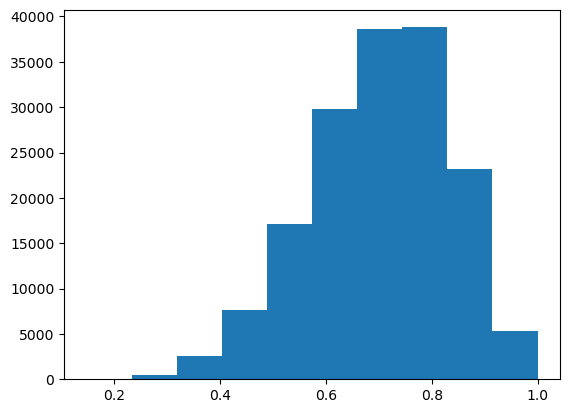

CPU times: user 202 ms, sys: 26.4 ms, total: 228 ms
Wall time: 275 ms


In [5]:
%%time

plt.hist(edges['weight'], 10)
plt.show()

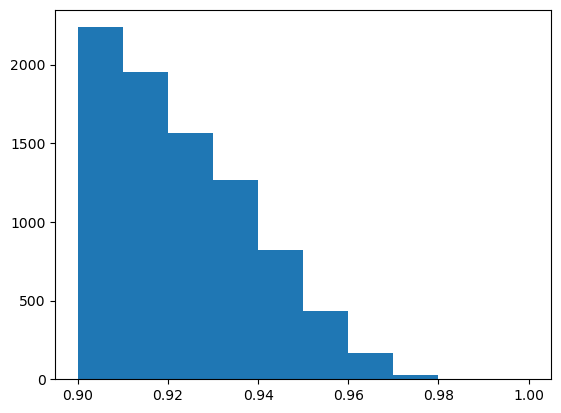

CPU times: user 165 ms, sys: 8.1 ms, total: 173 ms
Wall time: 175 ms


In [6]:
%%time

# Filter out weaker connections.
edges = edges.query('(source != target) & (weight >= 0.9) & (weight < 1.000000)')

plt.hist(edges['weight'], 10)
plt.show()

## Build Network Object

Separate Graph of non-Marsden? Average per year of non-Marsden to Marsden by keyword?

In [7]:
%%time

# Initialize graph object.
G = nx.from_pandas_edgelist(edges, 'source', 'target', ['weight'])

# Add nodes.
nodes = list( dict.fromkeys( edges['source'].values.tolist() + edges['target'].values.tolist() ))
nodes = pd.DataFrame(nodes, columns = ['source'])
G.add_nodes_from(nodes)

print (nx.info(G))

Graph with 375 nodes and 8480 edges
CPU times: user 45.9 ms, sys: 4.02 ms, total: 49.9 ms
Wall time: 51.3 ms


### Network Metrics

In [8]:
%%time

# Measure network density.
density = nx.density(G)
print (f"Network density: {density:.3f}")

# Determine connectivity.
print (f"Is the network connected? {nx.is_connected(G)}")

Network density: 0.121
Is the network connected? False
CPU times: user 1.68 ms, sys: 173 µs, total: 1.85 ms
Wall time: 1.8 ms


### Node Attributes

In [9]:
%%time

# Set degree attributes.
nx.set_node_attributes(G, dict(G.degree(G.nodes())), 'degree') 
print ('...degrees assigned')

# Find centrality measures.
betweenness_dict = nx.betweenness_centrality(G)
print ('...betweenness measured')
eigenvector_dict = nx.eigenvector_centrality(G)
print ('...eigenvector measured')
degree_cent_dict = nx.degree_centrality(G)
print ('...centrality measured')

# Assign centrality measures.
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')
nx.set_node_attributes(G, degree_cent_dict, 'degree_cent')

...degrees assigned
...betweenness measured
...eigenvector measured
...centrality measured
CPU times: user 1.63 s, sys: 12.5 ms, total: 1.64 s
Wall time: 1.65 s


### Find Communities

Commented out because process takes too long; need to filter more.

In [10]:
# %%time

# communities= community.naive_greedy_modularity_communities(G)

# modularity_dict = {}
# for i, c in enumerate(communities):
#     for name in c:
#         modularity_dict[name] = i
        
# nx.set_node_attributes(G, modularity_dict, 'modularity')

### Add Metadata as Node Attribute

In [11]:
%%time

# nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

# # Add metadata as node attributes.
# nx.set_node_attributes(G, pd.Series(nodes.meta_mjp_id, index = nodes.index).to_dict(), 'mjp_id')
# nx.set_node_attributes(G, pd.Series(nodes.meta_magazine, index = nodes.index).to_dict(), 'magazine')
# nx.set_node_attributes(G, pd.Series(nodes.meta_type, index = nodes.index).to_dict(), 'genre')
# nx.set_node_attributes(G, pd.Series(nodes.meta_date, index = nodes.index).to_dict(), 'date')
# nx.set_node_attributes(G, pd.Series(nodes.meta_year, index = nodes.index).to_dict(), 'year')

# Assign node metadata.
for c in data.columns:
    c_dict = {}
    col_name = str(c).replace('meta_', '')
    
    for r in data.itertuples():    
        c_dict[ r.vector ] = getattr(r, c)
        
        nx.set_node_attributes(G, c_dict, col_name)

CPU times: user 3.89 s, sys: 16.3 ms, total: 3.9 s
Wall time: 3.92 s


### Save Network Graph Object

In [12]:
%%time

graph = json_graph.node_link_data(G)

graph_json = json.dumps(graph)

with open(abs_dir + "GitHub/DH2022_SemanticEmergence/Data_Outputs/network-vectors.json", "w") as f:
    f.write(graph_json)

CPU times: user 47.1 ms, sys: 5.97 ms, total: 53 ms
Wall time: 55.6 ms
